### Importing Libraries

In [82]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GroupShuffleSplit, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load and Clean Data

In [83]:
df = pd.read_csv("youtube_final_csv.csv")

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50160 entries, 0 to 50159
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   video_id          50160 non-null  object
 1   title             50160 non-null  object
 2   topic             50160 non-null  object
 3   category_id       50160 non-null  int64 
 4   published_at      50160 non-null  object
 5   duration_seconds  50160 non-null  int64 
 6   video_definition  50160 non-null  object
 7   captions_flag     50160 non-null  bool  
 8   channel_id        50160 non-null  object
 9   channel_title     50160 non-null  object
 10  subscriber_count  50160 non-null  int64 
 11  total_videos      50160 non-null  int64 
 12  channel_age_days  50160 non-null  int64 
 13  views             50160 non-null  int64 
 14  likes             50160 non-null  int64 
 15  comments          50160 non-null  int64 
dtypes: bool(1), int64(8), object(7)
memory usage: 5.8+ MB


In [85]:
df.head()

,video_id,title,topic,category_id,published_at,duration_seconds,video_definition,captions_flag,channel_id,channel_title,subscriber_count,total_videos,channel_age_days,views,likes,comments
0,0BkEej0H1VU,*SMALL* Apartment Makeover w/ Surprise REVEAL!...,Hobby,22,2025-05-15T20:50:21Z,1493,hd,False,UCtwzsvzRCfPddq2gPlgKW1w,Lone Fox,1770000,485,2810,312359,19516,949
1,nL6DN0CWRWI,transforming my apartment 🏡🌷 i got a new couch...,Hobby,26,2024-05-26T17:00:34Z,1508,hd,False,UCFGQGLGZU1TgX-PhawwxjJg,annika's leaf,1070000,308,3314,353355,14823,727
2,gAgAYyo1O0o,Scandi-Style Studio Apartment Makeover With Po...,Hobby,26,2025-10-25T15:01:20Z,1798,hd,True,UCrh9tOpAY2-Ev5pRssXq2Wg,Alexandra Gater,888000,422,4020,350306,26864,1018
3,3EJu45Tkbyc,*196 sq ft* Organic Modern Studio Apartment Ma...,Hobby,26,2025-09-20T15:00:07Z,1821,hd,True,UCrh9tOpAY2-Ev5pRssXq2Wg,Alexandra Gater,888000,422,4020,458367,33976,1458
4,cShkxcg_la0,Small APARTMENT MAKEOVER 2024 :: Budget AirBnB...,Hobby,26,2024-03-18T17:00:31Z,2203,hd,False,UCbQj1aJiioDM8g0tmGmtC_w,This Crazy Life,457000,787,3009,490393,17309,1610


In [86]:
df.describe()

,category_id,duration_seconds,subscriber_count,total_videos,channel_age_days,views,likes,comments
count,50160.000000,50160.000000,5.016000e+04,50160.000000,50160.000000,5.016000e+04,5.016000e+04,50160.000000
mean,22.571531,2422.810825,2.977674e+06,5172.923405,3236.794597,2.709607e+06,3.010090e+04,1119.361643
std,6.164992,6201.971156,1.061033e+07,28809.301109,1826.909349,3.278482e+07,1.861561e+05,6548.073127
min,1.000000,240.000000,0.000000e+00,1.000000,3.000000,1.000000e+03,0.000000e+00,0.000000
25%,22.000000,630.000000,5.350000e+04,213.000000,1809.000000,2.033125e+04,4.250000e+02,29.000000
50%,24.000000,1199.000000,3.230000e+05,565.000000,3121.000000,1.385370e+05,2.630000e+03,141.000000
75%,27.000000,1990.000000,1.580000e+06,1505.000000,4581.000000,8.132555e+05,1.387225e+04,596.000000
max,29.000000,367231.000000,4.500000e+08,643411.000000,7446.000000,3.580474e+09,1.299725e+07,550394.000000


In [87]:
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
df = df.drop_duplicates(subset=['video_id'])

df = df[df['views'] > 0]
df = df[df['likes'] <= df['views']]

df['captions_flag'] = df['captions_flag'].astype(str)
df['video_definition'] = df['video_definition'].astype(str)
df['category_id'] = df['category_id'].astype(str)

### Duration Cleaning

In [88]:
df['duration_seconds'] = df['duration_seconds'].clip(5, 7200)
df['duration_minutes'] = df['duration_seconds'] / 60
df['subscriber_count_log'] = np.log1p(df['subscriber_count'])


### Calculate Target Feature

In [89]:
df['engagement_rate_log'] = (
    np.log1p(df['likes']) + np.log1p(df['comments'])
) / np.log1p(df['views'])

target = 'engagement_rate_log'


### Cyclic encodiing For Time Based Features

In [90]:
df['publish_hour'] = df['published_at'].dt.hour
df['publish_dayofweek'] = df['published_at'].dt.dayofweek

df['publish_hour_sin'] = np.sin(2*np.pi*df['publish_hour']/24)
df['publish_hour_cos'] = np.cos(2*np.pi*df['publish_hour']/24)
df['publish_dow_sin'] = np.sin(2*np.pi*df['publish_dayofweek']/7)
df['publish_dow_cos'] = np.cos(2*np.pi*df['publish_dayofweek']/7)


### Feature Engineering

In [91]:
df['is_hd'] = (df['video_definition'] == "hd").astype(int)
df['title_length'] = df['title'].str.len()
df['title_words'] = df['title'].str.split().str.len()
df['title_exclamation'] = df['title'].str.count('!')
df['title_question'] = df['title'].str.count('\\?')


### Dropping Extra Columns

In [92]:
drop_cols = [
    'video_id','topic','title','published_at','channel_title',
    'duration_seconds','views','likes','comments','subscriber_count',
    'publish_hour','publish_dayofweek','video_definition'
]
df.drop(columns=drop_cols, inplace=True, errors="ignore")


In [93]:
df['category_id'].unique()

array(['22', '26', '28', '24', '1', '19', '23', '20', '27', '25', '10',
       '15', '17', '29', '2'], dtype=object)

### Spliting the Data in Test and Train Set

In [94]:
categorical_features = ['category_id', 'captions_flag']
numeric_features = [
    'total_videos','channel_age_days','title_length','title_words',
    'title_exclamation','title_question',
    'duration_minutes','publish_hour_sin','publish_hour_cos',
    'publish_dow_sin','publish_dow_cos',
    'subscriber_count_log','is_hd'
]

all_features = categorical_features + numeric_features

X = df[all_features].copy()
y = df[target].copy()
groups = df['channel_id']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()


### Tearget encoding for Category Id

In [95]:
train_means = y_train.groupby(X_train['category_id']).mean()
X_train['category_te'] = X_train['category_id'].map(train_means)
X_test['category_te']  = X_test['category_id'].map(train_means)
numeric_features.append('category_te')


In [96]:
import joblib
joblib.dump(train_means, "category_te_mapping_new.pkl")

['category_te_mapping_new.pkl']

### Capping outlier Values

In [97]:
def robust_clip(t, v):
    q1, q3 = t.quantile([0.25,0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return t.clip(lo, hi), v.clip(lo, hi)

for col in ['total_videos','channel_age_days']:
    X_train[col], X_test[col] = robust_clip(X_train[col], X_test[col])


### Converting the categorical features to Category type

In [98]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


### Halving Grid Search

In [99]:
base_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    subsample=0.85,        
    colsample_bylevel=1.0,
    colsample_bytree=0.8,  
    reg_alpha=5,           
    reg_lambda=10,         
    verbosity=0,
    enable_categorical=True,
    tree_method="hist"
)


param_grid = {
    "learning_rate": [0.03, 0.05],
    "max_depth": [4, 5],
    "min_child_weight": [1, 3],   
    "colsample_bytree": [0.7, 0.8],   
    "gamma": [0, 1],     
    "n_estimators": [300, 600]     
}

search = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    factor=2,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1
)

search.fit(X_train, y_train)
print("BEST PARAMS:", search.best_params_)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 616
max_resources_: 39475
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 64
n_resources: 616
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 1
n_candidates: 32
n_resources: 1232
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 16
n_resources: 2464
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 3
n_candidates: 8
n_resources: 4928
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 4
n_resources: 9856
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 5
n_candidates: 2
n_resources: 19712
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 6
n_candidates: 1
n_resources: 39424
Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS: {'colsample_bytree': 0.8, 'gamma': 0, 'lea

### Fitting final Model on entire Train set

In [ ]:
final_model = XGBRegressor(
    **search.best_params_,       
    objective="reg:squarederror",
    subsample=0.85,                    
    reg_alpha=5,                 
    reg_lambda=10,               
    random_state=42,
    verbosity=0,
    enable_categorical=True,
    tree_method="hist"
)

final_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [ ]:
y_pred = np.clip(final_model.predict(X_test), y_train.min(), y_train.max())
y_train_pred = np.clip(final_model.predict(X_train), y_train.min(), y_train.max())

print("\n====== TEST PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

print("\n====== TRAIN PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R2:", r2_score(y_train, y_train_pred))


====== TEST PERFORMANCE ======
MAE: 0.15058916864625246
RMSE: 0.20587921000986514
R2: 0.29910394151129227

====== TRAIN PERFORMANCE ======
MAE: 0.1318864331357275
RMSE: 0.1832572093017762
R2: 0.43190025473561156


### Saving Model in pkl file

In [ ]:
import joblib

# save the best model from your halving search
joblib.dump(final_model, "xgb_final_new.pkl")

print("Model saved successfully!")

Model saved successfully!


### Optimal Duration


Selected sample indices: [24547, 25259, 8449, 49481, 20292]


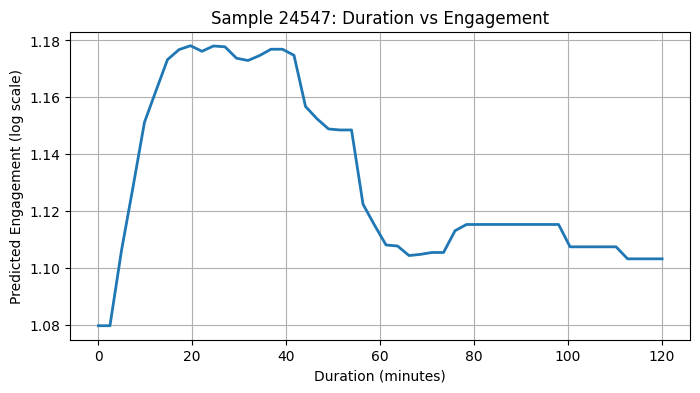

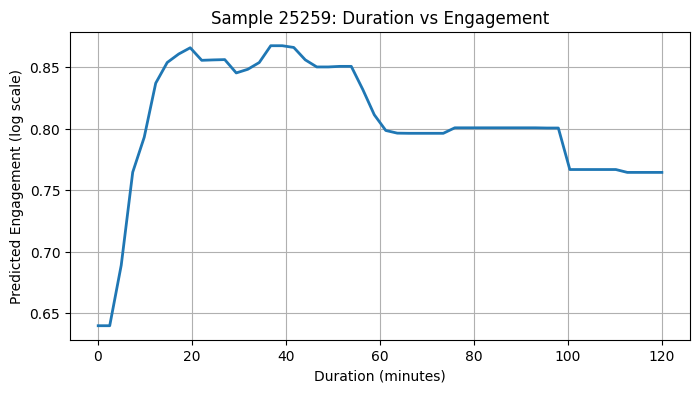

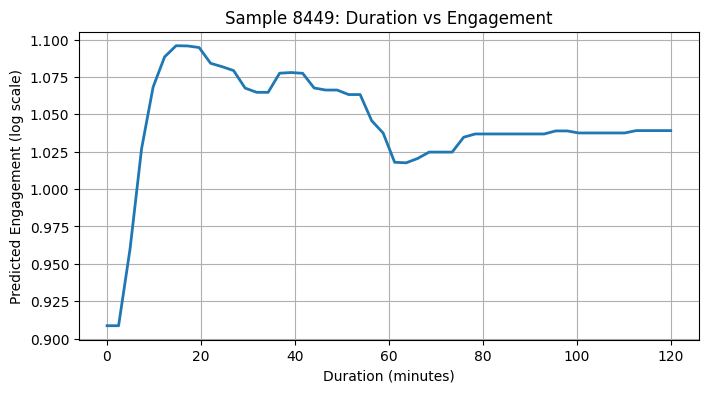

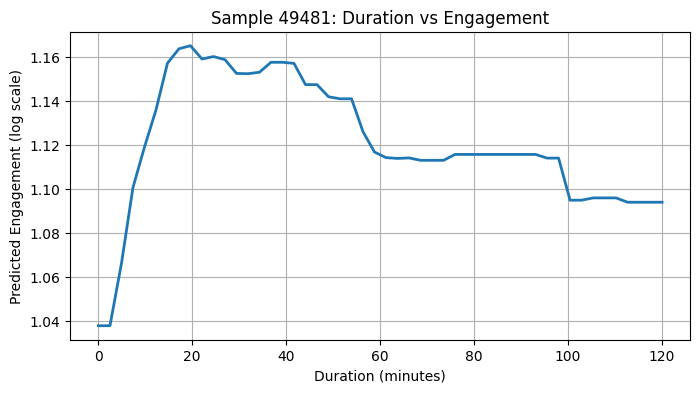

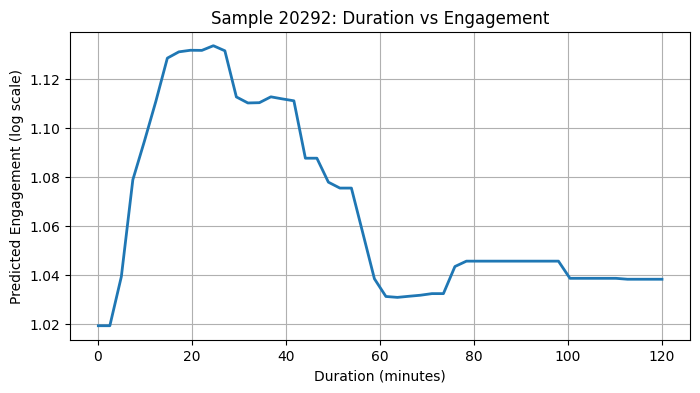


SAMPLE 24547
Original Engagement %         : 32.44%
Optimal Duration (minutes)    : 19.66
Max Engagement at Optimal %   : 32.48%
Improvement %                 : 0.12%

SAMPLE 25259
Original Engagement %         : 23.57%
Optimal Duration (minutes)    : 36.79
Max Engagement at Optimal %   : 23.81%
Improvement %                 : 1.01%

SAMPLE 8449
Original Engagement %         : 27.93%
Optimal Duration (minutes)    : 14.77
Max Engagement at Optimal %   : 29.92%
Improvement %                 : 7.12%

SAMPLE 49481
Original Engagement %         : 31.96%
Optimal Duration (minutes)    : 19.66
Max Engagement at Optimal %   : 32.06%
Improvement %                 : 0.32%

SAMPLE 20292
Original Engagement %         : 30.87%
Optimal Duration (minutes)    : 24.56
Max Engagement at Optimal %   : 31.06%
Improvement %                 : 0.64%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================
# FUNCTION: Convert log-engagement → human-friendly % estimate
# (Smooth, realistic approximation)
# ==============================================================
def log_to_percentage(log_value):
    ratio = np.exp(log_value) / 10
    return ratio * 100


# Your categorical columns
cat_cols = ['category_id', 'captions_flag']


# ==============================================================
# 1) PICK 5 RANDOM SAMPLES FROM X_test
# ==============================================================
np.random.seed(42)
sample_indices = np.random.choice(X_test.index, size=5, replace=False)

print("\nSelected sample indices:", sample_indices.tolist())


# ==============================================================
# 2) FOR EACH SAMPLE → VARY DURATION & PREDICT
# ==============================================================

duration_range = np.linspace(5, 7200, 50)
duration_minutes_range = duration_range / 60

results = {}

for idx in sample_indices:

    base_row = X_test.loc[idx].copy()   # 1 sample (Series)
    duration_scores = []

    for dur_min in duration_minutes_range:

        updated_row = base_row.copy()
        updated_row['duration_minutes'] = dur_min

        temp_df = pd.DataFrame([updated_row])

        for col in cat_cols:
            temp_df[col] = temp_df[col].astype("category")

        pred_log = final_model.predict(temp_df)[0]
        duration_scores.append(pred_log)

    results[idx] = {
        "duration_min": duration_minutes_range,
        "eng_score_log": np.array(duration_scores)
    }

    # PLOT
    plt.figure(figsize=(8, 4))
    plt.plot(duration_minutes_range, duration_scores, linewidth=2)
    plt.xlabel("Duration (minutes)")
    plt.ylabel("Predicted Engagement (log scale)")
    plt.title(f"Sample {idx}: Duration vs Engagement")
    plt.grid(True)
    plt.show()


# ==============================================================
# 3) FIND OPTIMAL DURATION + % IMPROVEMENT
# ==============================================================

for idx in sample_indices:

    # ---- ORIGINAL PREDICTION ----
    orig_row = X_test.loc[idx].copy()
    orig_df = pd.DataFrame([orig_row])

    for col in cat_cols:
        orig_df[col] = orig_df[col].astype("category")

    orig_pred_log = final_model.predict(orig_df).item()
    orig_pred_pct = log_to_percentage(orig_pred_log)


    # ---- OPTIMAL VALUES ----
    duration_min = results[idx]["duration_min"]
    eng_scores_log = results[idx]["eng_score_log"]

    best_idx = np.argmax(eng_scores_log)
    best_duration = duration_min[best_idx]
    best_score_log = eng_scores_log[best_idx]
    best_score_pct = log_to_percentage(best_score_log)

    improvement_pct = ((best_score_pct - orig_pred_pct) / abs(orig_pred_pct)) * 100


    # ---- PRINT RESULTS ----
    print("\n==============================")
    print(f"SAMPLE {idx}")
    print("==============================")
    print(f"Original Engagement %         : {orig_pred_pct:.2f}%")
    print(f"Optimal Duration (minutes)    : {best_duration:.2f}")
    print(f"Max Engagement at Optimal %   : {best_score_pct:.2f}%")
    print(f"Improvement %                 : {improvement_pct:.2f}%")
